In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# Kalman filter


- Continuous Gaussian linear Markov filter
- Parametric filter: $\mu$, $\sigma^2$, the gaussian is completely defined by its mean and variance
- Unimodal
- Google uses it to locate other cars

**Advantage:**

Instead of dealing with full histograms, we just deals with the parameters

**Disadvantage:**

Assuming gaussians in certain cases (multimodal) might not be a good model

# The model (Moving object)
## Definition

$S_{n+1} = aS_{n} + U_n + W_n$

$X_n = S_n + V_n$

Similar to the [additive noise histogram filter](https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/Additive%20noise%20Histogram%20Filters.ipynb)  but with some fundamental differences:
- $S_n$ is a continuous process. No more discrete states
- $W_n$ is zero mean gaussian
- $V_n$ is zero mean gaussian

## Notation change
Unfortunately the notation used for kalman filters differs from the notation usually used for HMMs and histogram filters. 

To be in consonance with the actual biography we will just change the notation

$(1)\quad X_{n+1} = aX_n + b_nU_n + W_n$

$(2) \quad Z_n = hX_n + V_n \quad \quad \quad$

**$X$**: The state. In our example, the robot position.  - $S$

**$Z$**: The observation. - $X$

**$W$**: The process noise. For the walking robot, high variance of $W$ means that the robot walking is not accurate.

**$a$**: The state transition factor. In our example, it is 1. If it is higher than one, this means it will be exponentially accelerating. Will make more sense with the Kalman Vector filter on the next section.

**$b_n$, $U_n$**: The control input model. Will make more sense with the Kalman Vector filter on the next section. For our walking robot, it will be one.

**$h$**: Observation model. Maps the true state space into the observation space

**$V_n$**: Observation Noise

# Generative model

In [37]:
def generate_sample_(X_o = 0, sigma_w = 0.1,sigma_v = 0.1, h = 1, a = 1, b = 1, U = 1, steps = 10):
    # Call the package function. This is just an example
    # X_o: Initial position
    # sigma_w: Variance of W
    # sigma_v: Variance of V
    # First I am in state X_o. Remeber that X is S in our old model
    # So our first measurement is based on equation (2)
    real_positions = [X_o]
    measurements = [h*X_o + np.random.normal(0,sigma_v)]
    X_k = X_o
    for i in range(steps):
        # This is equation (1)
        X_k = a*X_k + b*U + np.random.normal(0,sigma_w)
        real_positions.append(X_k)
        # This is equation (2)
        Z = h*X_k + np.random.normal(0,sigma_v)
        measurements.append(Z)
    return measurements, real_positions

Lets plot how some processes look

## Measurement noise much greater than Process noise: : $\sigma_w^2 << \sigma_v^2$
Lots of error observing but walking smoothly

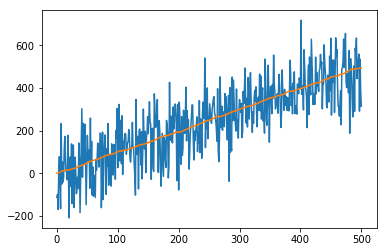

In [41]:
from kalman1d import generate_sample
measurements, real_positions = generate_sample(X_o = 0, sigma_w = 1,
                                               sigma_v = 100, 
                                               h = 1, a = 1, b = 1, U = 1, 
                                               steps = 500)
plt.plot(measurements)
plt.plot(real_positions)
plt.show()

## Process noise much greater than  Measurement noise: $\sigma_w^2 >> \sigma_v^2$
Lots of error to do the walking

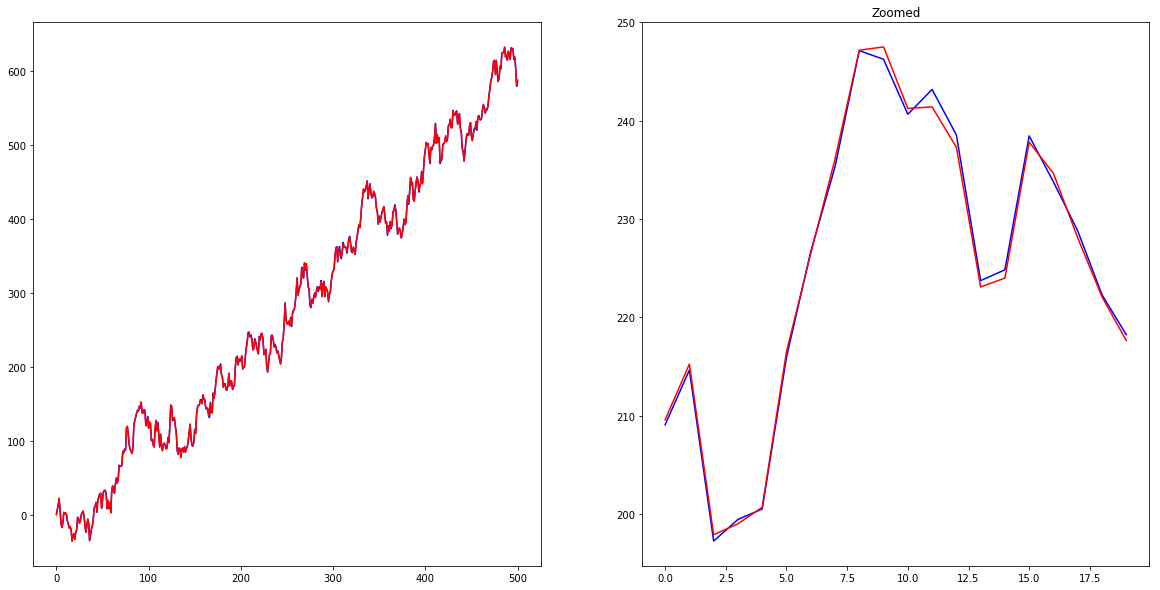

In [42]:
measurements, real_positions = generate_sample(X_o = 0, 
                                               sigma_w = 10,
                                               sigma_v = 1, 
                                               h = 1, a = 1, b = 1, U = 1, steps = 500)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(measurements, 'b')
plt.plot(real_positions, 'r')
plt.subplot(1,2,2)
plt.plot(measurements[200:220], 'b')
plt.plot(real_positions[200:220], 'r')
plt.title('Zoomed')
plt.show()

# The model

Instead of having probabilities, we have densities. We use lowercase p for density, uppercase P for probability

**Process noise** (W) - Moving noise in our example:

$p(W) = N(0,\sigma_w^2) = \Large{\frac{1}{\sigma_w \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(W)}{\sigma_w^2}^2}}$

$\mu_w = 0$

**Observation noise / Measurement error**:

$p(V) = N(0,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(V)}{\sigma_v^2}^2}}$

$\mu_v = 0$

## The observation density - $Z_n = h X_n + V$
This is the density before observing given than we are on a specific state

V is Gaussian with mean 0, so $Z_n$ given we are in state $X_n$ will be Gaussian with mean of $h X_n$. 

$E\{Z_n\} = E\{h X_n + V\} = h E\{X_n\} + E\{V\} = hX_n$

$\sigma_z^2 = \sigma_v^2$

$p(Z_n|X_n) = N(h X_n,\sigma_v^2) = \Large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(Z_n-h X_n)}{\sigma_v^2}^2}}$


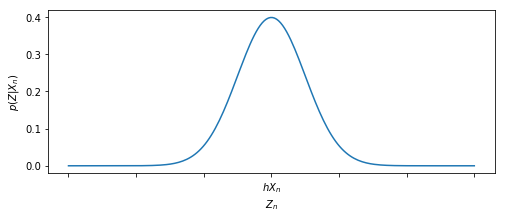

In [43]:
from kalman1d import plot_gaussian
_ = plot_gaussian(N = 6, y_label = "$p(Z|X_n)$", x_label = "$Z_n$", center_label_tick = "$hX_n$",figsize=(8,3))

Is this the likelihood?

## The likelihood -  $\mathcal{L}(X_n|Z_n)$ = $p(Z_n|X_n)$ 

Remember that for the likelihood, the observation $Z_n$ is fixed and $X_n$ varies

$p(Z=Z_n|X_n) = N(h X_n,\sigma_v^2) = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(Z_n-h X_n)}{\sigma_v^2}^2}} = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(h\frac{Z_n}{h}-h X_n)}{\sigma_v^2}^2}} = 
\large{\frac{1}{\sigma_v \sqrt{2\pi}} e^{-\frac{1}{2}\frac{(\frac{Z_n}{h}-X_n)}{\frac{\sigma_v^2}{h^2}}^2}} =
\alpha N(\frac{Z_n}{h},\frac{\sigma_v^2}{h^2})$

This is equivalent to a Gaussian pdf that depends on $X_k$ with mean $\frac{Z}{h}$ and variance $\frac{\sigma_v^2}{h^2}$

If h = 1, then the distribution of the likelihood is the same as the distribution of the observation

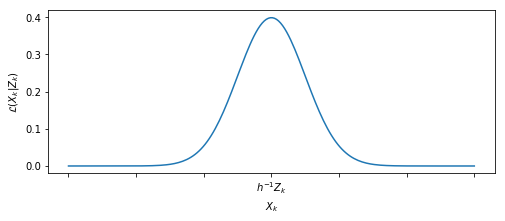

In [7]:
_ =plot_gaussian(N = 6, y_label = "$\mathcal{L}(X_k|Z_k)$", x_label = "$X_k$", 
                 center_label_tick = "$h^{-1}Z_k$",figsize=(8,3))

## Prior (belief): my belief before measuring

$p(X_n) = N(\hat{x}_{n}, p_{0}) = \Large{\frac{1}{\sqrt{2\pi p_{0}}} e^{-\frac{1}{2}\frac{(X_n-\hat{x}_{0})}{p_{0}}^2}}$

When starting, $p_{0}$ is the initial uncertainty (The variance). Usually larger than $\sigma_w^2$ and $\sigma_v^2$.

$\hat{x}_{0}$ is the initial guess and usually zero.

## Posterior: probability of a state given the measurements


$\large{p(X_n|Z_n) = \alpha p(Z_n|X_n)p(X_n)}$

**Bayes**:

$\large{p(X_n|Z_n) = \frac{p(Z_n|X_n)p(X_n)}{p(Z_n)}}$

$p(Z_n) = \int_{-\infty}^{\infty} {p(Z_n|X = x)p(x)} dx$

Because likelihood and prior are Gaussians, the posterior is Gaussian

# The filter
## The goal. Where am I?
Estimate my position $X_n$ given the observations $Z_1, ..., Z_n$
## Update - Bayes
Given the prior and the likelihood, find the posterior $X_k$

$Z_n = h X_n + V$

## Predict - Sum of random variable

$X_{n+1} = aX_{n} + bU_n + W$

## Loop
My prediction is my prior, so observe X again and update, and so on ...

# Update - Bayes

## Product of Gaussians pdfs

https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/pdfs/gaussians_convolutions_lecture3.pdf

The product of 2 Gaussians pdfs with parameters $\mu_u$, $\sigma_u^2$ and $\mu_{v}$,$\sigma_{v}^2$ is proportional to a Gaussian with parameters $\mu_{x}$,$\sigma_{x}^2$ calculated as follows

$p(X) = \alpha p(U)p(V)$

$\mu_{x} = \Large{\frac{\sigma_u^2\mu_v +\mu_u \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$

Parallel resistances analogy

$\sigma_{x}^2 = \Large{\frac{\sigma_u^2 \sigma_v^2}{\sigma_u^2 + \sigma_v^2}}$


### Implementation

In [44]:
def gauss_pdf_mult(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return [new_mean, new_var]

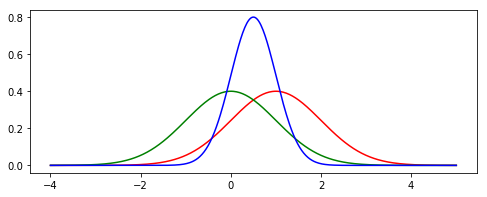

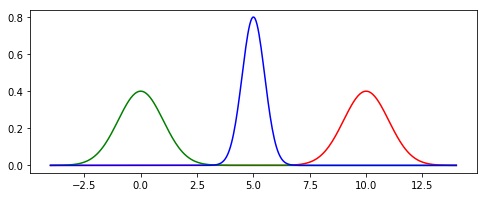

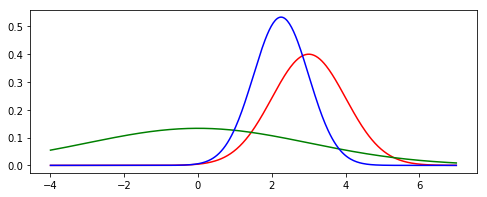

In [45]:
def plot_product(mu_u, sig_u, mu_v, sig_v, points=400):
    f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
    N = 4
    x = np.linspace(min(mu_u,mu_v)-N*sig_u, max(mu_u,mu_v)+N*sig_u, points)
    
    _, prior =plot_gaussian(mu = mu_u, sig = sig_u, N = 6, ax = ax, x=x, color = 'r')
    _, likelihood =plot_gaussian(mu = mu_v, sig = sig_v, ax = ax, x=x, color = 'g')

    mu_y, sig_y = gauss_pdf_mult(mu_u, sig_u, mu_v, sig_v)

    _ = plot_gaussian(mu = mu_y, sig = sig_y, N = 6, ax = ax, x=x, color = 'b')
    plt.show()
    
sig_u = 1; sig_v = 1; mu_u = 1; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 1; mu_u = 10; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)
sig_u = 1; sig_v = 3; mu_u = 3; mu_v = 0
plot_product(mu_u, sig_u, mu_v, sig_v)

The blue is the result of the product of the green and red pdf's. Keep in mind that the blue is normalized after multiplication (The denominator on the Bayes rule)

### Conclusions
- The variance of the product of 2 pdfs is always less than the minimum of both.
- The product of 2 pdfs is not the same as the product of 2 random variables
- The update always lowers the uncertainty

## Lets applied it to the model

$\large{p(X_n|Z_n) = \alpha p(Z_n|X_n)p(X_n)}$

We observe $Z$ and we get the likelihood $N(h^{-1}Z,\sigma_v^2h^{-2})$. Remember h and $\sigma_v^2$ are known

$(1)\quad\large{N(\hat{X}_{n|n}, p_{n|n})  = \alpha N(h^{-1}Z,\sigma_v^2h^{-2})N(\hat{X}_{n|n-1}, p_{n|n-1})}$

Notation clarification:

$\hat{X}_{n|n-1}$: This is the estimate of the position in the previous step. For the first step $X_0$

$p_{n|n-1}$: This is the uncertainty of the position estimation in the previous step. For the first step $p_0$

$\hat{X}_{n|n}$: The estimate of the position at the n step given that we got the nth observation

$p_{n|n}$: The uncertainty of the position estimation given that we got the nth observation

**Gaussians properties of product of pdfs**

$(2)\quad \sigma_x^2 = ({\sigma_a^2}^{-1} + {\sigma_b^2}^{-1})^{-1}$

$(3)\quad \mu_x = \frac{\sigma_x^2 }{\sigma_a^2}\mu_a + \frac{\sigma_x^2}{\sigma_b^2}\mu_b = 
\sigma_x^2[\frac{\mu_a }{\sigma_a^2} + \frac{\mu_b}{\sigma_b^2}] $

**Identifying each parameter**

Equation (1) with (3)

$\sigma_x^2 = p_{n|n} \quad \sigma_a^2 = \frac{\sigma_v^2}{h^2} \quad \sigma_b^2 = p_{n|n-1}\quad$

Equation (1) with (2)

$\mu_x = \hat{X}_{n|n} \quad \mu_a = h^{-1}Z \quad \mu_b = \hat{X}_{n|n-1}$

**Replacing and simplifying**

$\hat{X}_{n|n} = p_{n|n}[\frac{hZ}{\sigma_v^2} +  \frac{\hat{X}_{n|n-1}}{p_{n|n-1}}]$

$p_{n|n} = \Large{\frac{p_{n|n-1} \sigma_v^2}{p_{n|n-1}h^{2} + \sigma_v^2}}$

## The implementation

In [47]:
def update(h, sigma_v, Z, X_est_prior, P_prior):
    P = P_prior*sigma_v/(P_prior*(h**2) + sigma_v)
    X_est = P*(h*Z/sigma_v + X_est_prior/P_prior)
    return X_est, P

## The Kalman Gain

$K = \frac{p_{n|n-1}{h}}{p_{n|n-1}h^{2} + \sigma_v^2} \quad 1 - hK = \frac{p_{n|n-1}{\sigma_v^2}}{p_{n|n-1}h^{2} + \sigma_v^2}$

$\hat{X}_{n|n} = p_{n|n}[\frac{hZ}{\sigma_v^2} +  \frac{\hat{X}_{n|n-1}}{p_{n|n-1}}] = 
\hat{X}_{n|n-1} + K(Z-h\hat{X}_{n|n-1})$

$p_{n|n} = \Large{\frac{p_{n|n-1} \sigma_v^2}{p_{n|n-1}h^{2} + \sigma_v^2}} = p_{n|n-1}(1-hK)$

In [48]:
def update_with_kalman_gain(h, sigma_v, Z, X_est_prior, P_prior):
    K = P_prior*h/(P_prior*h**2+sigma_v)
    P = P_prior*(1-h*K)
    X_est = X_est_prior + K*(Z-h*X_est_prior)
    return X_est, P, K

# Predict - Convolution of Gaussians

The sum of random variables is equal to a Gaussian where the mean and the variances are the sum of the mean and variances respectively

$X = U + V$

$\mu_{X} = \mu_{U} +\mu_V$

$\sigma_{X}^2 = \sigma_{U}^2 +\sigma_V^2$

## Implementation

In [49]:
def gauss_var_add(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

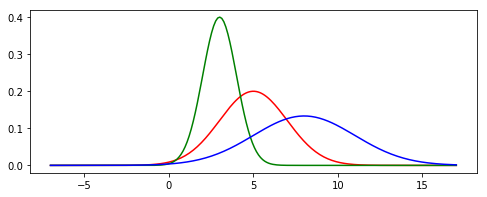

In [50]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
mu_s = 5
sig_s = 2
mu_w = 3
sig_w = 1
x, posterior = plot_gaussian(mu = mu_s, sig = sig_s, N = 6, ax = ax, color = 'r')
W = plot_gaussian(mu = mu_w, sig = sig_w, N = 6, ax = ax, x=x, color = 'g')

mu_p, sig_p = gauss_var_add(mu_s,sig_s, mu_w,sig_w)

W = plot_gaussian(mu = mu_p, sig = sig_p, N = 6, ax = ax, x=x, color = 'b')
plt.show()

### Applied to the model:

**Model equation**

$X_{n|n-1} = aX_{n|n} + bU_{n} + W$


** Replacing**

$\mu_W = 0$

$\hat{X}_{n|n-1} = a\hat{X}_{n|n} +\mu_w + bU_k = a\hat{X}_{n|n} + bU_n$

$p_{n|n-1} = a^2p_{n|n} +\sigma_w^2$

now update!

In [52]:
def predict(sigma_w, X_updated, P_updated, a = 1, b = 1, U = 1):
    X_predicted = a*X_updated + b*U
    P_predicted = (a**2)*sigma_w + P_updated
    return X_predicted, P_predicted

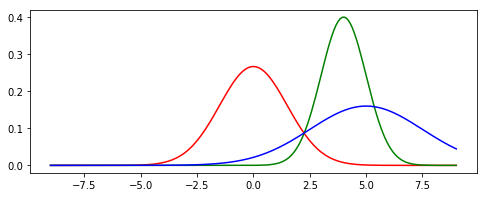

In [53]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = (8,3))
mu_w = 0
sigma_w = 1.5 
X_updated = 4
P_updated = 1

x, posterior = plot_gaussian(mu = mu_w, sig = sigma_w, N = 6, ax = ax, color = 'r')

W = plot_gaussian(mu = X_updated, sig = P_updated, N = 6, ax = ax, x=x, color = 'g')

mu_p, sig_p = predict(sigma_w, X_updated, P_updated, a = 1, b = 1, U = 1)

W = plot_gaussian(mu = mu_p, sig = sig_p, N = 6, ax = ax, x=x, color = 'b')
plt.show()

The red is the process error (walking error), the green is the robot position with its error, and the blue is the prediction for the robots next position

# Continuous walking robot example (Not discrete)
$X_{k+1} = X_k + Vel + W_k$

$Z_k = X_k + V_k$

$Vel$ is the velocity in units per iterations. It is $bU$ in the formal definition

In [57]:
from kalman1d import Kalman1D

## Example 1: Observation noise much higher than walking noise
Speed of the robot $bU = 1$

In [58]:
kalman = Kalman1D(sigma_v=10, sigma_w=0.1, X_0=0, P_0=50, U=1, b=1)
print(kalman)

Model parameters:
Observation Noise Variance: 10
Process Noise Variance: 0.1
Initial guess: 0
Initial uncertainty: 50
h=1, a=1, b=1, U=1


### Ideal generative model

In this example, just for demonstration purposes, we generate a sample where we are suppose to pick a robot that has a perfect walking and a perfect sensor. 
Anyway, the model still has observation variance 10 and a process noise of 0.1

Both measurements and ground truth are equal:
measurements: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
ground truth: [0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


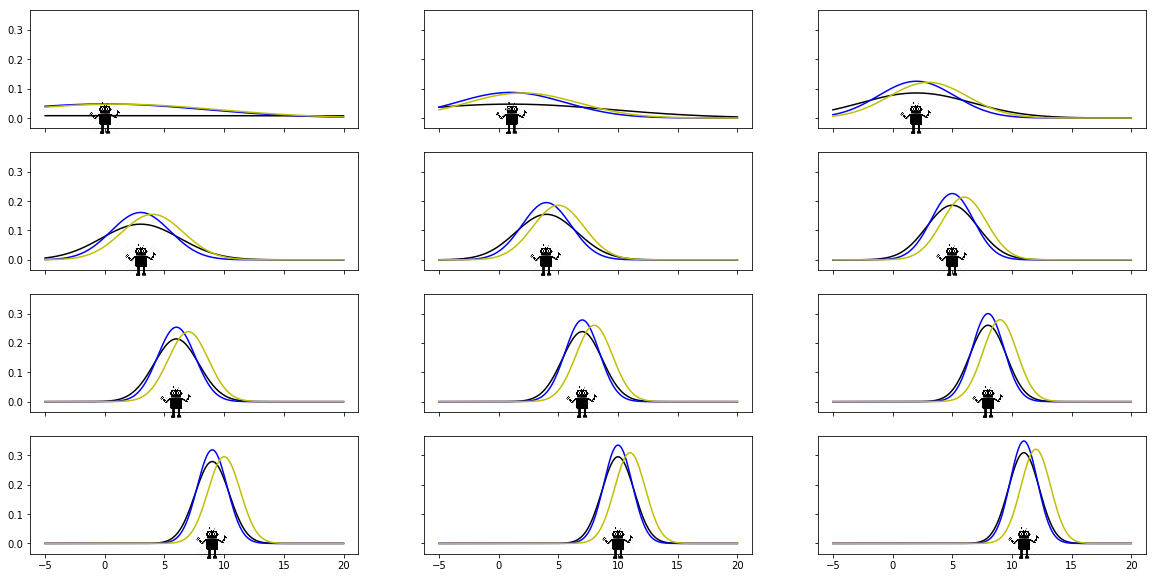

In [59]:
measurements, real_positions = kalman.generate_ideal_samples(1000)
print('Both measurements and ground truth are equal:')
print('measurements:',measurements[:10])
print('ground truth:',real_positions[:10])

# Lets filter and plot the results
kalman.filter()
kalman.plot_kalman_filter_steps(x_limits=[-5,20], show_legends=False)

In [60]:
kalman.plot_interactive_kalman_filter(initial_slider_pos=2, max_number_of_steps=50)

### Ideal walking, real observing generative model

Model parameters:
Observation Noise Variance: 10
Process Noise Variance: 1
Initial guess: 0
Initial uncertainty: 50
h=1, a=1, b=1, U=1
Both measurements and ground truth are equal:
measurements: [8.875542894055773, -1.1225251690656775, -13.849905641018495, 5.2744550478408625, -0.40775276291609686, -19.21306892658488, -7.341489007285617, 16.283357225704236, 4.6538063440047, 5.667410666592313]
ground truth: [0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


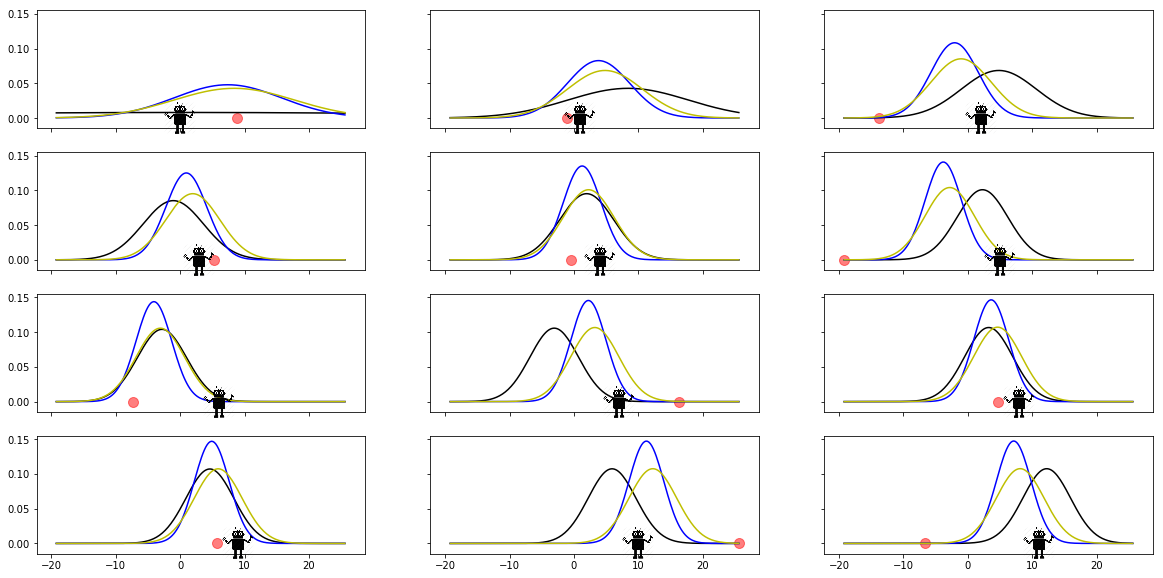

In [61]:
kalman_1 = Kalman1D(sigma_v=10, sigma_w=1, X_0=0, P_0=50, U=1, b=1)
print(kalman_1)

measurements, real_positions = kalman_1.generate_ideal_walking_samples(1000)
print('Both measurements and ground truth are equal:')
print('measurements:',measurements[:10])
print('ground truth:',real_positions[:10])

# Lets filter and plot the results
kalman_1.filter()
kalman_1.plot_kalman_filter_steps(show_legends=False)

In [62]:
kalman_1.plot_interactive_kalman_filter(initial_slider_pos=20, max_number_of_steps=50, points = 400)

### Real walking, real observing generative model

Both measurements and ground truth are equal:
measurements: [6.157955593490564, -5.486638565262079, -16.384535924261773, -2.612227264920229, 7.166110150475339, 19.785591483744213, -11.023296807562179, 14.33305398332655, 16.85357305688272, -6.765389292634456]
ground truth: [0, 0.9757619133695608, 2.0263221232444266, 2.922633163042138, 3.911355496114783, 4.776412471007972, 5.575180185086549, 6.643149635294287, 7.579802273085249, 8.493770762291748]


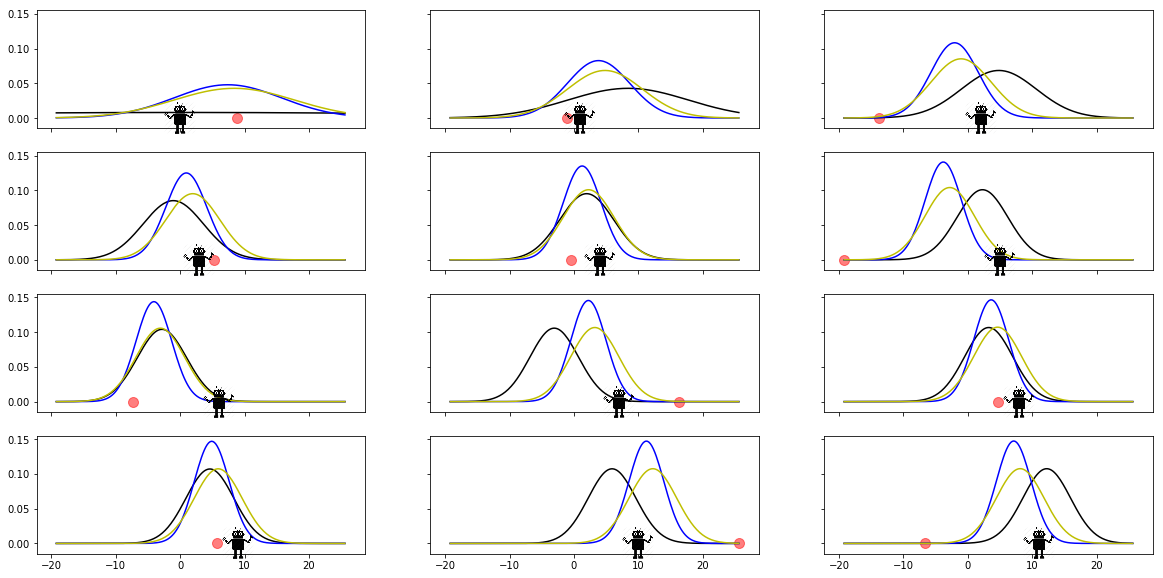

In [64]:
measurements, real_positions = kalman.generate_model_samples(1000)
print('Both measurements and ground truth are equal:')
print('measurements:',measurements[:10])
print('ground truth:',real_positions[:10])

# Lets filter and plot the results
kalman_1.filter()
kalman_1.plot_kalman_filter_steps(show_legends=False)

In [23]:
kalman_1.plot_interactive_kalman_filter(initial_slider_pos=20, max_number_of_steps=30, points = 400)

## Example 2: Robot stays in position

In [65]:
from ipywidgets import *
def plot_kalman_result(sigma_v=10, sigma_w=0.1):
    plt.figure(figsize=(20,10))
    kalman_2 = Kalman1D(sigma_v=sigma_v, sigma_w=sigma_w, X_0=0, P_0=50, U=0, b=1)
    _ = kalman_2.generate_model_samples(10000)
    kalman_2.filter()
    kalman_2.plot_kalman_filter_results()
    #ax = plt.gca()
    #print(ax.get_ylim())
    plt.show()
interact(plot_kalman_result, 
         sigma_v = widgets.IntSlider(min=0, max=40,step=1, value=10,continuous_update=False),
         sigma_w = widgets.FloatSlider(min=0, max=2,step=0.1, value=0.1,continuous_update=False)
        )

<function __main__.plot_kalman_result>

# 1D Kalman filter Limitations

## Error in the model definition

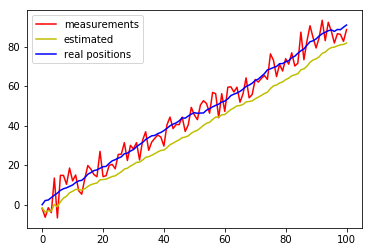

In [41]:
kalman_generative_model = Kalman1D(sigma_v=5, sigma_w=0.5, X_0=0, P_0=50, U=1, b=1)
samples = kalman_generative_model.generate_model_samples(100)

kalman_filter_model = Kalman1D(sigma_v=10, sigma_w=0.1, X_0=0, P_0=50, U=0, b=1)
kalman_filter_model.filter(*samples)
kalman_filter_model.plot_kalman_filter_results()